In [23]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy as sp
import scipy.ndimage
%matplotlib inline

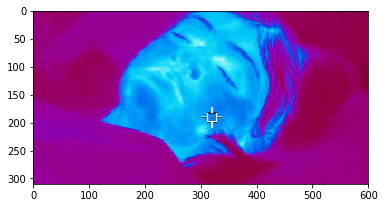

In [24]:
image = cv2.imread('image.jpg')
image = image[50:360, 0:600]
plt.imshow(image)

In [25]:
image.shape

(310, 600, 3)

In [26]:
def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
        """
        3D Anisotropic diffusion.
 
        Usage:
        stackout = anisodiff(stack, niter, kappa, gamma, option)
 
        Arguments:
                stack  - input stack
                niter  - number of iterations
                kappa  - conduction coefficient 20-100 ?
                gamma  - max value of .25 for stability
                step   - tuple, the distance between adjacent pixels in (z,y,x)
                option - 1 Perona Malik diffusion equation No 1
                         2 Perona Malik diffusion equation No 2
                ploton - if True, the middle z-plane will be plotted on every
                         iteration
 
        Returns:
                stackout   - diffused stack.
 
        kappa controls conduction as a function of gradient.  If kappa is low
        small intensity gradients are able to block conduction and hence diffusion
        across step edges.  A large value reduces the influence of intensity
        gradients on conduction.
 
        gamma controls speed of diffusion (you usually want it at a maximum of
        0.25)
 
        step is used to scale the gradients in case the spacing between adjacent
        pixels differs in the x,y and/or z axes
 
        Diffusion equation 1 favours high contrast edges over low contrast ones.
        Diffusion equation 2 favours wide regions over smaller ones.
 
        Reference:
        P. Perona and J. Malik.
        Scale-space and edge detection using ansotropic diffusion.
        IEEE Transactions on Pattern Analysis and Machine Intelligence,
        12(7):629-639, July 1990.
 
        Original MATLAB code by Peter Kovesi  
        School of Computer Science & Software Engineering
        The University of Western Australia
        pk @ csse uwa edu au
        <http://www.csse.uwa.edu.au>
 
        Translated to Python and optimised by Alistair Muldal
        Department of Pharmacology
        University of Oxford
        <alistair.muldal@pharm.ox.ac.uk>
 
        June 2000  original version.      
        March 2002 corrected diffusion eqn No 2.
        July 2012 translated to Python
        """
 
        # ...you could always diffuse each color channel independently if you
        # really want
        if stack.ndim == 4:
                warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
                stack = stack.mean(3)
 
        # initialize output array
        stack = stack.astype('float32')
        stackout = stack.copy()
 
        # initialize some internal variables
        deltaS = np.zeros_like(stackout)
        deltaE = deltaS.copy()
        deltaD = deltaS.copy()
        NS = deltaS.copy()
        EW = deltaS.copy()
        UD = deltaS.copy()
        gS = np.ones_like(stackout)
        gE = gS.copy()
        gD = gS.copy()
 
        # create the plot figure, if requested
        if ploton:
                import pylab as pl
                from time import sleep
 
                showplane = stack.shape[0]//2
 
                fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
                ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
                ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
                ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
                ax1.set_title("Original stack (Z = %i)" %showplane)
                ax2.set_title("Iteration 0")
 
                fig.canvas.draw()
 
        for ii in range(niter):
 
                # calculate the diffs
                deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
                deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
                deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)
 
                # conduction gradients (only need to compute one per dim!)
                if option == 1:
                        gD = np.exp(-(deltaD/kappa)**2.)/step[0]
                        gS = np.exp(-(deltaS/kappa)**2.)/step[1]
                        gE = np.exp(-(deltaE/kappa)**2.)/step[2]
                elif option == 2:
                        gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
                        gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
                        gE = 1./(1.+(deltaE/kappa)**2.)/step[2]
 
                # update matrices
                D = gD*deltaD
                E = gE*deltaE
                S = gS*deltaS
 
                # subtract a copy that has been shifted 'Up/North/West' by one
                # pixel. don't as questions. just do it. trust me.
                UD[:] = D
                NS[:] = S
                EW[:] = E
                UD[1:,: ,: ] -= D[:-1,:  ,:  ]
                NS[: ,1:,: ] -= S[:  ,:-1,:  ]
                EW[: ,: ,1:] -= E[:  ,:  ,:-1]
 
                # update the image
                stackout += gamma*(UD+NS+EW)
 
                if ploton:
                        iterstring = "Iteration %i" %(ii+1)
                        ih.set_data(stackout[showplane,...].squeeze())
                        ax2.set_title(iterstring)
                        fig.canvas.draw()
                        # sleep(0.01)
 
        return stackout

In [27]:
niter = 5
delta_t = 0.1
kappa = 20
option = 2
step = np.ones(3)

In [28]:
ad = anisodiff3(image, niter=niter, gamma=delta_t, option=option, step=step)

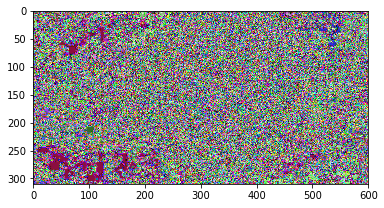

In [29]:
plt.imshow(ad)

## Background foreground separation

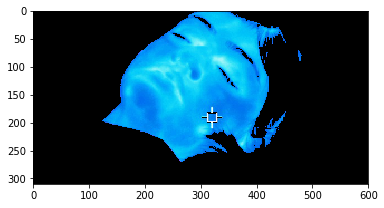

In [30]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret1,th = cv2.threshold(image_gray,127,255,cv2.THRESH_BINARY)
res = cv2.bitwise_and(image, image, mask = th)
plt.imshow(res)

In [31]:
ad3 = anisodiff3(res, niter=niter, gamma=.2, option=option, step=step)

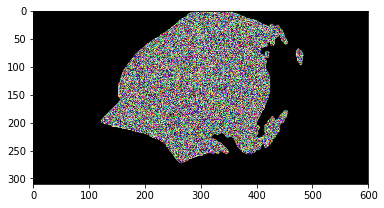

In [32]:
plt.imshow(ad3)

In [33]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False):
 
        # ...you could always diffuse each color channel independently if you
        # really want
        if img.ndim == 3:
                warnings.warn("Only grayscale images allowed, converting to 2D matrix")
                img = img.mean(2)
 
        # initialize output array
        img = img.astype('float32')
        imgout = img.copy()
 
        # initialize some internal variables
        deltaS = np.zeros_like(imgout)
        deltaE = deltaS.copy()
        NS = deltaS.copy()
        EW = deltaS.copy()
        gS = np.ones_like(imgout)
        gE = gS.copy()
 
        # create the plot figure, if requested
        if ploton:
                import pylab as pl
                from time import sleep
 
                fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
                ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
                ax1.imshow(img,interpolation='nearest')
                ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
                ax1.set_title("Original image")
                ax2.set_title("Iteration 0")
 
                fig.canvas.draw()
 
        for ii in range(niter):
 
                # calculate the diffs
                deltaS[:-1,: ] = np.diff(imgout,axis=0)
                deltaE[: ,:-1] = np.diff(imgout,axis=1)
 
                # conduction gradients (only need to compute one per dim!)
                if option == 1:
                        gS = np.exp(-(deltaS/kappa)**2.)/step[0]
                        gE = np.exp(-(deltaE/kappa)**2.)/step[1]
                elif option == 2:
                        gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
                        gE = 1./(1.+(deltaE/kappa)**2.)/step[1]
 
                # update matrices
                E = gE*deltaE
                S = gS*deltaS
 
                # subtract a copy that has been shifted 'North/West' by one
                # pixel. don't as questions. just do it. trust me.
                NS[:] = S
                EW[:] = E
                NS[1:,:] -= S[:-1,:]
                EW[:,1:] -= E[:,:-1]
 
                # update the image
                imgout += gamma*(NS+EW)
 
                if ploton:
                        iterstring = "Iteration %i" %(ii+1)
                        ih.set_data(imgout)
                        ax2.set_title(iterstring)
                        fig.canvas.draw()
                        # sleep(0.01)
 
        return imgout

In [34]:
ad = anisodiff(res, niter=niter, gamma=delta_t, option=option, step=step)

C:\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Only grayscale images allowed, converting to 2D matrix
  


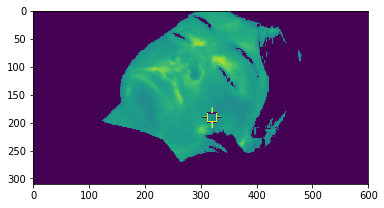

In [35]:
plt.imshow(ad)

## Writing own anisodiff func

In [53]:
def anisodiff3D(vol, num_iter, delta_t, kappa, option, voxel_spacing):
    # Convert input vol to double
    vol = vol.astype(float)
    
    # Useful variables
    rows, cols, pags = vol.shape
    
    # PDE (Partial differential equation) initial condition.
    diff_vol = vol;
    
    x = voxel_spacing[0];
    y = voxel_spacing[1];
    z = voxel_spacing[2];
    dx = 1;
    dy = 1;
    dz = z/x;
    dd = np.sqrt(dx**2+dy**2);
    dh = np.sqrt(dx**2+dz**2);
    dc = np.sqrt(dd**2+dz**2);
    
    
    # 3D convolution masks - finite differences.
    h1 = np.zeros((3,3,3)); h1[1,1,1] = -1; h1[0,1,1] = 1;
    h2 = np.zeros((3,3,3)); h2[1,1,1] = -1; h2[2,1,1] = 1;
    h3 = np.zeros((3,3,3)); h3[1,1,1] = -1; h3[1,0,1] = 1;
    h4 = np.zeros((3,3,3)); h4[1,1,1] = -1; h4[1,2,1] = 1;
    h5 = np.zeros((3,3,3)); h5[1,1,1] = -1; h5[1,1,2] = 1;
    h6 = np.zeros((3,3,3)); h6[1,1,1] = -1; h6[1,1,0] = 1;

    h7 = np.zeros((3,3,3)); h7[1,1,1] = -1; h7[0,0,2] = 1;
    h8 = np.zeros((3,3,3)); h8[1,1,1] = -1; h8[0,0,1] = 1;
    h9 = np.zeros((3,3,3)); h9[1,1,1] = -1; h9[0,0,0] = 1;
    h10 = np.zeros((3,3,3)); h10[1,1,1] = -1; h10[0,1,2] = 1;
    h11 = np.zeros((3,3,3)); h11[1,1,1] = -1; h11[0,1,0] = 1;
    h12 = np.zeros((3,3,3)); h12[1,1,1] = -1; h12[0,2,2] = 1;
    h13 = np.zeros((3,3,3)); h13[1,1,1] = -1; h13[0,2,1] = 1;
    h14 = np.zeros((3,3,3)); h14[1,1,1] = -1; h14[0,2,0] = 1;

    h15 = np.zeros((3,3,3)); h15[1,1,1] = -1; h15[1,0,2] = 1;
    h16 = np.zeros((3,3,3)); h16[1,1,1] = -1; h16[1,0,0] = 1;
    h17 = np.zeros((3,3,3)); h17[1,1,1] = -1; h17[1,2,2] = 1;
    h18 = np.zeros((3,3,3)); h18[1,1,1] = -1; h18[1,2,0] = 1;

    h19 = np.zeros((3,3,3)); h19[1,1,1] = -1; h19[2,0,2] = 1;
    h20 = np.zeros((3,3,3)); h20[1,1,1] = -1; h20[2,0,1] = 1;
    h21 = np.zeros((3,3,3)); h21[1,1,1] = -1; h21[2,0,0] = 1;
    h22 = np.zeros((3,3,3)); h22[1,1,1] = -1; h22[2,1,2] = 1;
    h23 = np.zeros((3,3,3)); h23[1,1,1] = -1; h23[2,1,0] = 1;
    h24 = np.zeros((3,3,3)); h24[1,1,1] = -1; h24[2,2,2] = 1;
    h25 = np.zeros((3,3,3)); h25[1,1,1] = -1; h25[2,2,1] = 1;
    h26 = np.zeros((3,3,3)); h26[1,1,1] = -1; h26[2,2,0] = 1;
    
    # Anisotropic diffustion
    for t in range(0, num_iter):
        for p in range(0, pags-2):
            diff3pp = diff_vol[:,:,p:p+2]
            aux = sp.ndimage.convolve(diff3pp, h1); nabla1 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h2); nabla2 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h3); nabla3 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h4); nabla4 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h5); nabla5 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h6); nabla6 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h7); nabla7 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h8); nabla8 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h9); nabla9 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h10); nabla10 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h11); nabla11 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h12); nabla12 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h13); nabla13 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h14); nabla14 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h15); nabla15 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h16); nabla16 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h17); nabla17 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h18); nabla18 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h19); nabla19 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h20); nabla20 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h21); nabla21 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h22); nabla22 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h23); nabla23 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h24); nabla24 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h25); nabla25 = aux[:,:,1]
            aux = sp.ndimage.convolve(diff3pp, h26); nabla26 = aux[:,:,1]
            
            # Diffusion function
            if option == 1:
                c1 = np.exp(-(nabla1/kappa)**2);
                c2 = np.exp(-(nabla2/kappa)**2);
                c3 = np.exp(-(nabla3/kappa)**2);
                c4 = np.exp(-(nabla4/kappa)**2);
                c5 = np.exp(-(nabla5/kappa)**2);
                c6 = np.exp(-(nabla6/kappa)**2);
                c7 = np.exp(-(nabla7/kappa)**2);
                c8 = np.exp(-(nabla8/kappa)**2);
                c9 = np.exp(-(nabla9/kappa)**2);
                c10 = np.exp(-(nabla10/kappa)**2);
                c11 = np.exp(-(nabla11/kappa)**2);
                c12 = np.exp(-(nabla12/kappa)**2);
                c13 = np.exp(-(nabla13/kappa)**2);
                c14 = np.exp(-(nabla14/kappa)**2);
                c15 = np.exp(-(nabla15/kappa)**2);
                c16 = np.exp(-(nabla16/kappa)**2);
                c17 = np.exp(-(nabla17/kappa)**2);
                c18 = np.exp(-(nabla18/kappa)**2);
                c19 = np.exp(-(nabla19/kappa)**2);
                c20 = np.exp(-(nabla20/kappa)**2);
                c21 = np.exp(-(nabla21/kappa)**2);
                c22 = np.exp(-(nabla22/kappa)**2);
                c23 = np.exp(-(nabla23/kappa)**2);
                c24 = np.exp(-(nabla24/kappa)**2);
                c25 = np.exp(-(nabla25/kappa)**2);
                c26 = np.exp(-(nabla26/kappa)**2);            
            elif option == 2:
                c1 = 1./(1 + (nabla1/kappa)**2);
                c2 = 1./(1 + (nabla2/kappa)**2);
                c3 = 1./(1 + (nabla3/kappa)**2);
                c4 = 1./(1 + (nabla4/kappa)**2);
                c5 = 1./(1 + (nabla5/kappa)**2);
                c6 = 1./(1 + (nabla6/kappa)**2);
                c7 = 1./(1 + (nabla7/kappa)**2);
                c8 = 1./(1 + (nabla8/kappa)**2);
                c9 = 1./(1 + (nabla9/kappa)**2);
                c10 = 1./(1 + (nabla10/kappa)**2);
                c11 = 1./(1 + (nabla11/kappa)**2);
                c12 = 1./(1 + (nabla12/kappa)**2); 
                c13 = 1./(1 + (nabla13/kappa)**2);
                c14 = 1./(1 + (nabla14/kappa)**2);
                c15 = 1./(1 + (nabla15/kappa)**2);
                c16 = 1./(1 + (nabla16/kappa)**2);
                c17 = 1./(1 + (nabla17/kappa)**2);
                c18 = 1./(1 + (nabla18/kappa)**2); 
                c19 = 1./(1 + (nabla19/kappa)**2);
                c20 = 1./(1 + (nabla20/kappa)**2);
                c21 = 1./(1 + (nabla21/kappa)**2);
                c22 = 1./(1 + (nabla22/kappa)**2);
                c23 = 1./(1 + (nabla23/kappa)**2);
                c24 = 1./(1 + (nabla24/kappa)**2);             
                c25 = 1./(1 + (nabla25/kappa)**2);
                c26 = 1./(1 + (nabla26/kappa)**2);             

        # Discrete PDE solution
        diff_vol[:,:,p+1] = diff_vol[:,:,p+1] + delta_t*( 
                        (1/(dz**2))*c1*nabla1 + (1/(dz**2))*c2*nabla2 +  
                        (1/(dx**2))*c3*nabla3 + (1/(dx**2))*c4*nabla4 +  
                        (1/(dy**2))*c5*nabla5 + (1/(dy**2))*c6*nabla6 +  
                         
                        (1/(dc**2))*c7*nabla7 + (1/(dh**2))*c8*nabla8 +  
                        (1/(dc**2))*c9*nabla9 + (1/(dh**2))*c10*nabla10 +  
                        (1/(dh**2))*c11*nabla11 + (1/(dc**2))*c12*nabla12 +  
                        (1/(dh**2))*c13*nabla13 + (1/(dc**2))*c14*nabla14 +  
                         
                        (1/(dd**2))*c15*nabla15 + (1/(dd**2))*c16*nabla16 +  
                        (1/(dd**2))*c17*nabla17 + (1/(dd**2))*c18*nabla18 +  
                         
                        (1/(dc**2))*c19*nabla19 + (1/(dh**2))*c20*nabla20 +  
                        (1/(dc**2))*c21*nabla21 + (1/(dh**2))*c22*nabla22 +  
                        (1/(dh**2))*c23*nabla23 + (1/(dc**2))*c24*nabla24 +  
                        (1/(dh**2))*c25*nabla25 + (1/(dc**2))*c26*nabla26);
    return diff_vol
    

In [54]:
test = anisodiff3D(res, num_iter = 5, delta_t = 0.3, kappa=1, option=2, voxel_spacing=step)

In [55]:
plt.imshow(test)

ValueError: Floating point image RGB values must be in the 0..1 range.

In [45]:
se = np.ones((5,5))

In [46]:
BW = cv2.erode(test,se)
plt.imshow(BW)

ValueError: Floating point image RGB values must be in the 0..1 range.

In [47]:
BW2 = cv2.dilate(BW, se)
plt.imshow(BW2)

ValueError: Floating point image RGB values must be in the 0..1 range.

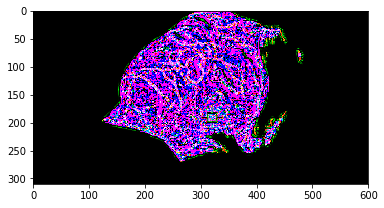

In [48]:
IM2 = cv2.morphologyEx(test, cv2.MORPH_TOPHAT, se)
plt.imshow(IM2)

In [49]:
img = IM2.astype(int)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)
 
ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False
 
while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
 
    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True
 
cv2.imshow("skel",skel)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: C:\OpenCv3\opencv\modules\imgproc\src\color.cpp:11010: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cv::cvtColor


In [ ]:
image = cv2.imread('another.jpg')
image = image[50:360, 0:600]
plt.imshow(image)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret1,th = cv2.threshold(image_gray,127,255,cv2.THRESH_BINARY)
res = cv2.bitwise_and(image, image, mask = th)
plt.imshow(res)
test = anisodiff3D(res, num_iter = 5, delta_t = 0.1, kappa=20, option=2, voxel_spacing=step)
BW = cv2.erode(test,se)
plt.imshow(BW)
BW2 = cv2.dilate(BW, se)
plt.imshow(BW2)
IM2 = cv2.morphologyEx(test, cv2.MORPH_TOPHAT, se)
plt.imshow(IM2)

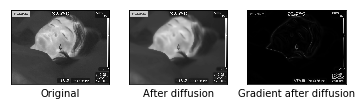

In [50]:
""" Perona Malik Diffusion
    for Edge Detection
"""

import numpy as np
from scipy import misc, ndimage
import matplotlib.pyplot as plt

# SETTINGS:
image_file = 'image.jpg'
iterations = 30
delta = 0.14
kappa = 15

# convert input image
im = misc.imread('image.jpg', flatten=True)
im = im.astype('float64')

# initial condition
u = im

# center pixel distances
dx = 1
dy = 1
dd = np.sqrt(2)

# 2D finite difference windows
windows = [
    np.array(
            [[0, 1, 0], [0, -1, 0], [0, 0, 0]], np.float64
    ),
    np.array(
            [[0, 0, 0], [0, -1, 0], [0, 1, 0]], np.float64
    ),
    np.array(
            [[0, 0, 0], [0, -1, 1], [0, 0, 0]], np.float64
    ),
    np.array(
            [[0, 0, 0], [1, -1, 0], [0, 0, 0]], np.float64
    ),
    np.array(
            [[0, 0, 1], [0, -1, 0], [0, 0, 0]], np.float64
    ),
    np.array(
            [[0, 0, 0], [0, -1, 0], [0, 0, 1]], np.float64
    ),
    np.array(
            [[0, 0, 0], [0, -1, 0], [1, 0, 0]], np.float64
    ),
    np.array(
            [[1, 0, 0], [0, -1, 0], [0, 0, 0]], np.float64
    ),
]

for r in range(iterations):
    # approximate gradients
    nabla = [ ndimage.filters.convolve(u, w) for w in windows ]

    # approximate diffusion function
    diff = [ 1./(1 + (n/kappa)**2) for n in nabla]

    # update image
    terms = [diff[i]*nabla[i] for i in range(4)]
    terms += [(1/(dd**2))*diff[i]*nabla[i] for i in range(4, 8)]
    u = u + delta*(sum(terms))


# Kernel for Gradient in x-direction
Kx = np.array(
    [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.int32
)
# Kernel for Gradient in y-direction
Ky = np.array(
    [[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.int32
)
# Apply kernels to the image
Ix = ndimage.filters.convolve(u, Kx)
Iy = ndimage.filters.convolve(u, Ky)

# return norm of (Ix, Iy)
G = np.hypot(Ix, Iy)

plt.subplot(1, 3, 1), plt.imshow(im, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.xlabel('Original')
plt.subplot(1, 3, 2), plt.imshow(u, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.xlabel('After diffusion')
plt.subplot(1, 3, 3), plt.imshow(G, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.xlabel('Gradient after diffusion')
plt.show()

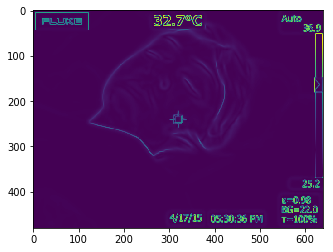

In [51]:
plt.imshow(G)

In [52]:
h2

NameError: name 'h2' is not defined